Welcome to the Predicting Housing Prices in Buenos Aires Project!

Get ready to dive into the exciting world of data science and predictive modelling! In this project, you'll explore real-world housing data from Buenos Aires, learn essential data wrangling and analysis techniques, and build models to predict property prices.

In [117]:
import warnings

from glob import glob

import numpy as np
import pandas as pd
from category_encoders import OneHotEncoder
import seaborn as sns
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

# 1. Predicting Price with Size

#### Prepare Data


We can clean our data files one-by-one but this isn't an issue when you're working with just three files, but imagine if you had several hundred! One way to automate the data importing and cleaning process is by writing a function. This will make sure that all our data undergoes the same process, and that our analysis is easily reproducible — something that's very important in science in general and data science in particular.

**Task 1.1:** Write a function named `wrangle` that takes a file path as an argument and returns a DataFrame.


In [4]:
def wrangle(file_path):
    
    # Read CSV file into a DataFrame
    df = pd.read_csv(file_path, sep=";", encoding="latin-1")

    return df

**Task 1.2:** Use our `wrangle` function to create a DataFrame `df` from the CSV file `data/buenos-aires-real-estate-1.csv`.

In [5]:
df = wrangle("data/buenos-aires-real-estate-1.csv")
print("df shape:", df.shape)
df.head()

df shape: (8606, 16)


,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
0,sell,apartment,|Argentina|Capital Federal|Villa Crespo|,"-34.6047834183,-58.4586812499",180000.0,USD,2729232.0,180000.0,120.0,110.0,1500.000000,1636.363636,NaN,4.0,NaN,http://villa-crespo.properati.com.ar/12egq_ven...
1,sell,house,|Argentina|Bs.As. G.B.A. Zona Oeste|La Matanza...,NaN,250000.0,USD,3790600.0,250000.0,117.0,120.0,2136.752137,2083.333333,NaN,4.0,NaN,http://ramos-mejia.properati.com.ar/s7pd_venta...
2,sell,house,|Argentina|Bs.As. G.B.A. Zona Oeste|Morón|Cast...,"-34.6497002,-58.658073",410000.0,USD,6216584.0,410000.0,410.0,220.0,1000.000000,1863.636364,NaN,NaN,NaN,http://castelar-moron.properati.com.ar/11vgn_v...
3,sell,house,|Argentina|Bs.As. G.B.A. Zona Oeste|Tres de Fe...,"-34.5957086,-58.5669503",180000.0,USD,2729232.0,180000.0,200.0,135.0,900.000000,1333.333333,NaN,5.0,NaN,http://tres-de-febrero.properati.com.ar/7f7u_v...
4,sell,apartment,|Argentina|Capital Federal|Chacarita|,"-34.5846508988,-58.4546932614",129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...


For this part, we want to build a model for apartments in Buenos Aires proper (`"Capital Federal"`) that cost less than \$400,000. Looking at the first five rows of our DataFrame, we can already see that there properties that fall outside those parameters. So our first cleaning task is to remove those observations from our dataset. Since we're using a function to import and clean our data, we'll need to make changes there. 

**Task 1.3:** Add to our `wrangle` function so that the DataFrame it returns only includes apartments in Buenos Aires (`"Capital Federal"`) that cost less than $400,000 USD. 

In [6]:
def wrangle(file_path):
    """Load and wrangle the housing data set."""
    # Load the CSV file
    df = pd.read_csv(file_path, sep=";", encoding="latin-1")

    # Subset the DataFrame with "Capital Federal" 
    mask = df["place_with_parent_names"].str.contains("Capital Federal", case=True)

    # Subset with "apartment"
    mask_apt = df["property_type"] == "apartment"

    # Subset with price less than to 400,000
    mask_price = df["price_aprox_usd"] < 400000


    # Apply all masks
    df = df[ mask & mask_apt &  mask_price]

    return df

In [7]:
df = wrangle("data/buenos-aires-real-estate-1.csv")
print("df shape:", df.shape)
df.head()

df shape: (1781, 16)


,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
0,sell,apartment,|Argentina|Capital Federal|Villa Crespo|,"-34.6047834183,-58.4586812499",180000.0,USD,2729232.0,180000.0,120.0,110.0,1500.000000,1636.363636,NaN,4.0,NaN,http://villa-crespo.properati.com.ar/12egq_ven...
4,sell,apartment,|Argentina|Capital Federal|Chacarita|,"-34.5846508988,-58.4546932614",129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...
9,sell,apartment,|Argentina|Capital Federal|Villa Luro|,"-34.6389789,-58.500115",87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...
11,sell,apartment,|Argentina|Capital Federal|Once|,"-34.6050060697,-58.4001162302",60000.0,USD,909744.0,60000.0,28.0,28.0,2142.857143,2142.857143,NaN,1.0,NaN,http://once.properati.com.ar/zz0q_venta_depart...
20,sell,apartment,|Argentina|Capital Federal|San Nicolás|,"-34.603898,-58.378617",69000.0,USD,1046205.6,69000.0,NaN,22.0,NaN,3136.363636,23.0,2.0,NaN,http://san-nicolas.properati.com.ar/rnju_venta...


We saw in the previous project that property size is an important factor in determining price. With that in mind, let's look at the distribution of apartment sizes in our dataset.

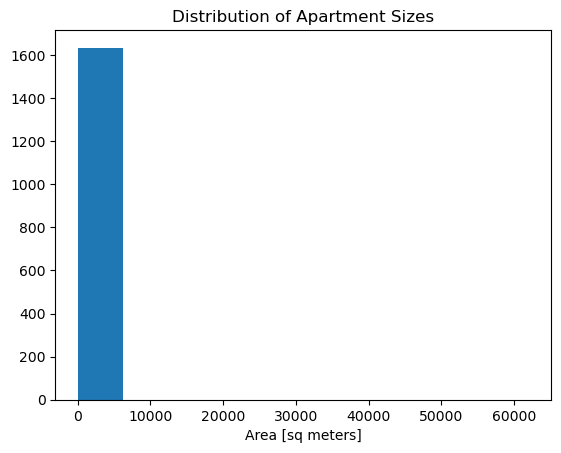

In [8]:
plt.hist(df["surface_covered_in_m2"])
plt.xlabel("Area [sq meters]")
plt.title("Distribution of Apartment Sizes");

When you see a histogram like the one above, it suggests that there are outliers in your dataset. This can affect model performance, especially in the sorts of linear models we'll learn about in this project. To confirm, let's look at the summary statistics for the "surface_covered_in_m2" feature.

In [9]:
df["surface_covered_in_m2"].describe()

count     1635.000000
mean        97.877064
std       1533.057610
min          0.000000
25%         38.000000
50%         50.000000
75%         73.000000
max      62034.000000
Name: surface_covered_in_m2, dtype: float64

The statistics above confirm what we suspected. While most of the apartments in our dataset are smaller that 73 square meters, there are some that are several thousand square meters. The best thing to do is to change our `wrangle` function and remove them from the dataset. 

**Task 1.4:** Add to our wrangle function so that it removes observations that are outliers in the `"surface_covered_in_m2"` column. Specifically, all observations should fall between the `0.1` and `0.9` quantiles for `"surface_covered_in_m2"`.

In [10]:
def wrangle(file_path):
    """Load and wrangle the housing data set."""
    # Load the CSV file
    df = pd.read_csv(file_path, sep=";", encoding="latin-1")

    # Subset the DataFrame with "Capital Federal" 
    mask = df["place_with_parent_names"].str.contains("Capital Federal", case=True)

    # Subset with "apartment"
    mask_apt = df["property_type"] == "apartment"

    # Subset with price less than to 400,000
    mask_price = df["price_aprox_usd"] < 400000

    # Apply all masks
    df = df[ mask & mask_apt & mask_price]
    
    # Remove outliers from "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]
    
    return df

Now that our dataset is free of outliers, it's time to start exploring the relationship between apartment size and price. 

In [11]:
df = wrangle("data/buenos-aires-real-estate-1.csv")
print("df shape:", df.shape)
df.head()

df shape: (1343, 16)


,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
4,sell,apartment,|Argentina|Capital Federal|Chacarita|,"-34.5846508988,-58.4546932614",129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...
9,sell,apartment,|Argentina|Capital Federal|Villa Luro|,"-34.6389789,-58.500115",87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...
29,sell,apartment,|Argentina|Capital Federal|Caballito|,"-34.615847,-58.459957",118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...
40,sell,apartment,|Argentina|Capital Federal|Constitución|,"-34.6252219,-58.3823825",57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364,http://constitucion.properati.com.ar/k2f0_vent...
41,sell,apartment,|Argentina|Capital Federal|Once|,"-34.6106102,-58.4125107",90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450,http://once.properati.com.ar/suwa_venta_depart...


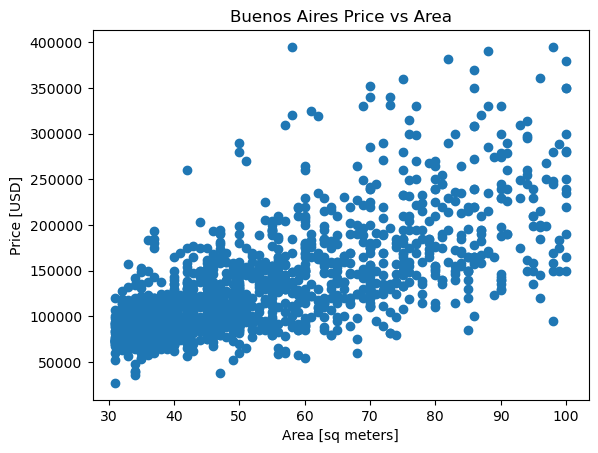

In [12]:
plt.scatter(df["surface_covered_in_m2"], df["price_aprox_usd"])
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title("Buenos Aires Price vs Area");

This plot suggests that there's a moderate positive correlation between apartment price and size. This means that if thing we want to predict is price, size will be a good feature to include.

#### Split

A key part in any model-building project is separating your **target** (the thing you want to predict) from your **features** (the information your model will use to make its predictions). Since this is our first model, we'll use just one feature: apartment size.

**Task 1.5:** Let's Create the feature matrix named `X_train`, which you'll use to train your model. And the target vector named `y_train`, which you'll use to train your model. Your target should be `"price_aprox_usd"`.

In [13]:
features = ["surface_covered_in_m2"]
X_train = df[features]

target = "price_aprox_usd"
y_train = df[target]

In [14]:
# Check our work
assert X_train.shape == (
    1343,
    1,
), f"The shape of `X_train` should be (1343, 1), not {X_train.shape}."

assert y_train.shape == (1343,)

#### Build Model


The first thing we need to do is create our model, in this case, one that uses linear regression.

**Task 1.6:** Instantiate a `LinearRegression`model named `model`.

In [15]:
model = LinearRegression()

In [16]:
# Check our work
assert isinstance(model, LinearRegression)

The second thing we need to do is use our data to train our model. Another way to say this is fit our model to the training data.

In [17]:
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


The final step is to evaluate our model. In order to do that, we'll start by seeing how well it performs when making predictions for data that it saw during training. So let's have it predict the price for the houses in our training set.

**Task 1.7:** Using our model's `predict` method, create a list of predictions for the observations in your feature matrix `X_train`.

In [18]:
y_pred_training = model.predict(X_train)
y_pred_training[:5]

array([169151.87330223, 106064.44707446, 133101.91545779, 106064.44707446,
       124089.42599668])

Now that we have predictions, we'll use them to assess our model's performance with the training data. We'll use the metric also called mean absolute error.

In [19]:
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 31248.26


Once your model is built and tested, it's time to share it with others. If you're presenting to simple linear model to a technical audience, they might appreciate an equation `y = mX + b`.

Regardless of how we write the equation, we need to find the values that our model has determined for the intercept and and coefficient. Fortunately, all trained models in scikit-learn store this information in the model itself. Let's start with the intercept.

**Task 1.8:** Extract the intercept from our model, and assign it to the variable `intercept`. And extract the coefficient associated to the variable *surface_covered_in_m2*

In [20]:
intercept = model.intercept_
print("Model Intercept:", intercept)
assert any([isinstance(intercept, int), isinstance(intercept, float)])

Model Intercept: 11433.307732797897


In [21]:
coefficient = round(model.coef_[0], 2)
print('Model coefficient for "surface_covered_in_m2":', coefficient)
assert any([isinstance(coefficient, int), isinstance(coefficient, float)])

Model coefficient for "surface_covered_in_m2": 2253.12


Now that we have our `intercept` and `coefficient`, we need to insert them into a string that we can print out the complete equation.

In [22]:
print(f"apartment_price = {intercept} + {coefficient} * surface_covered")

apartment_price = 11433.307732797897 + 2253.12 * surface_covered


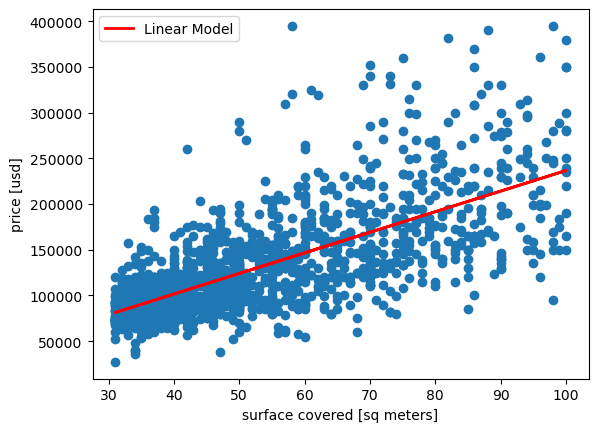

In [23]:
# Add a line to the plot
plt.plot(X_train, y_pred_training, color='red', linewidth=2, label='Linear Model')

plt.scatter(X_train, y_train)
plt.xlabel("surface covered [sq meters]")
plt.ylabel("price [usd]")
plt.legend();

# 2. Predicting Price with Location

#### Prepare Data

Use our `wrangle` function to create a DataFrame `frame1` from the CSV file `data/buenos-aires-real-estate-1.csv`.

In [24]:
frame1 = wrangle("data/buenos-aires-real-estate-1.csv")
print(frame1.info())
frame1.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1343 entries, 4 to 8604
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   1343 non-null   object 
 1   property_type               1343 non-null   object 
 2   place_with_parent_names     1343 non-null   object 
 3   lat-lon                     1300 non-null   object 
 4   price                       1343 non-null   float64
 5   currency                    1343 non-null   object 
 6   price_aprox_local_currency  1343 non-null   float64
 7   price_aprox_usd             1343 non-null   float64
 8   surface_total_in_m2         965 non-null    float64
 9   surface_covered_in_m2       1343 non-null   float64
 10  price_usd_per_m2            927 non-null    float64
 11  price_per_m2                1343 non-null   float64
 12  floor                       379 non-null    float64
 13  rooms                       1078 

,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
4,sell,apartment,|Argentina|Capital Federal|Chacarita|,"-34.5846508988,-58.4546932614",129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...
9,sell,apartment,|Argentina|Capital Federal|Villa Luro|,"-34.6389789,-58.500115",87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...
29,sell,apartment,|Argentina|Capital Federal|Caballito|,"-34.615847,-58.459957",118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...
40,sell,apartment,|Argentina|Capital Federal|Constitución|,"-34.6252219,-58.3823825",57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364,http://constitucion.properati.com.ar/k2f0_vent...
41,sell,apartment,|Argentina|Capital Federal|Once|,"-34.6106102,-58.4125107",90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450,http://once.properati.com.ar/suwa_venta_depart...


For our model, we're going to consider apartment location, specifically, latitude and longitude. Looking at the output from `frame1.info()`, we can see that the location information is in a single column where the data type is `object` (pandas term for `str` in this case). In order to build our model, we need latitude and longitude to each be in their own column where the data type is `float`. 

**Task 2.1:** Add to the `wrangle` function above so that, in the DataFrame it returns, the `"lat-lon"` column is replaced by separate `"lat"` and `"lon"` columns. Don't forget to also drop the `"lat-lon"` column. 

In [25]:
def wrangle(file_path):
    """Load and wrangle the housing data set."""
    # Load the CSV file
    df = pd.read_csv(file_path, sep=";", encoding="latin-1")

    # Subset the DataFrame with "Capital Federal" 
    mask = df["place_with_parent_names"].str.contains("Capital Federal", case=True)

    # Subset with "apartment"
    mask_apt = df["property_type"] == "apartment"

    # Subset with price less than to 400,000
    mask_price = df["price_aprox_usd"] < 400000

    # Apply all masks
    df = df[ mask & mask_apt & mask_price]
    
    # Remove outliers from "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Add columns 'lat' and 'lon'
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)

    # Drop columns "lat-lon"
    df.drop(columns=["lat-lon"], inplace=True)
    
    return df

In [26]:
frame1 = wrangle("data/buenos-aires-real-estate-1.csv")
print(frame1.info())
frame1.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1343 entries, 4 to 8604
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   1343 non-null   object 
 1   property_type               1343 non-null   object 
 2   place_with_parent_names     1343 non-null   object 
 3   price                       1343 non-null   float64
 4   currency                    1343 non-null   object 
 5   price_aprox_local_currency  1343 non-null   float64
 6   price_aprox_usd             1343 non-null   float64
 7   surface_total_in_m2         965 non-null    float64
 8   surface_covered_in_m2       1343 non-null   float64
 9   price_usd_per_m2            927 non-null    float64
 10  price_per_m2                1343 non-null   float64
 11  floor                       379 non-null    float64
 12  rooms                       1078 non-null   float64
 13  expenses                    349 n

,operation,property_type,place_with_parent_names,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon
4,sell,apartment,|Argentina|Capital Federal|Chacarita|,129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...,-34.584651,-58.454693
9,sell,apartment,|Argentina|Capital Federal|Villa Luro|,87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...,-34.638979,-58.500115
29,sell,apartment,|Argentina|Capital Federal|Caballito|,118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...,-34.615847,-58.459957
40,sell,apartment,|Argentina|Capital Federal|Constitución|,57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364,http://constitucion.properati.com.ar/k2f0_vent...,-34.625222,-58.382382
41,sell,apartment,|Argentina|Capital Federal|Once|,90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450,http://once.properati.com.ar/suwa_venta_depart...,-34.610610,-58.412511


In [27]:
# Check our work
assert (
    frame1.shape[0] == 1343
), f"`frame1` should have 1343 rows, not {frame1.shape[0]}."
assert frame1.shape[1] == 17, f"`frame1` should have 17 columns, not {frame1.shape[1]}."

**Task 2.2:** Use our revised `wrangle` function create a DataFrames `frame2` from the file `data/buenos-aires-real-estate-2.csv`.

In [28]:
frame2 = wrangle("data/buenos-aires-real-estate-2.csv")

As you can see, using a function is much quicker than cleaning each file individually like we did in the last project. Let's combine our DataFrames so we can use then to train our model.

**Task 2.3:** Use `pd.concat` to concatenate `frame1` and `frame2` into a new DataFrame `df`. Make sure you set the `ignore_index` argument to `True`.


In [29]:
df = pd.concat([frame1, frame2], ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2658 entries, 0 to 2657
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   2658 non-null   object 
 1   property_type               2658 non-null   object 
 2   place_with_parent_names     2658 non-null   object 
 3   price                       2658 non-null   float64
 4   currency                    2658 non-null   object 
 5   price_aprox_local_currency  2658 non-null   float64
 6   price_aprox_usd             2658 non-null   float64
 7   surface_total_in_m2         1898 non-null   float64
 8   surface_covered_in_m2       2658 non-null   float64
 9   price_usd_per_m2            1818 non-null   float64
 10  price_per_m2                2658 non-null   float64
 11  floor                       769 non-null    float64
 12  rooms                       2137 non-null   float64
 13  expenses                    688 n

,operation,property_type,place_with_parent_names,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon
0,sell,apartment,|Argentina|Capital Federal|Chacarita|,129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...,-34.584651,-58.454693
1,sell,apartment,|Argentina|Capital Federal|Villa Luro|,87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...,-34.638979,-58.500115
2,sell,apartment,|Argentina|Capital Federal|Caballito|,118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...,-34.615847,-58.459957
3,sell,apartment,|Argentina|Capital Federal|Constitución|,57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364,http://constitucion.properati.com.ar/k2f0_vent...,-34.625222,-58.382382
4,sell,apartment,|Argentina|Capital Federal|Once|,90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450,http://once.properati.com.ar/suwa_venta_depart...,-34.610610,-58.412511


In the previous section, we built a simple linear model that predicted apartment price based on one feature, `"surface_covered_in_m2"`. In this section, we're building a multiple linear regression model that predicts price based on two features, `"lon"` and `"lat"`. This means that our data visualizations now have to communicate three pieces of information: Longitude, latitude, and price. How can we represent these three attributes on a two-dimensional screen?

One option is to incorporate color into our scatter plot. For example, in the Mapbox scatter plot below, the location of each point represents latitude and longitude, and color represents price. 

In [30]:
fig = px.scatter_mapbox(
    df,  # Our DataFrame
    lat= "lat",
    lon= "lon",
    width=600,  # Width of map
    height=600,  # Height of map
    color= "price_aprox_usd",  # Color by price
    hover_data=["price_aprox_usd"],  # Display price when hovering mouse over house
)

fig.update_layout(mapbox_style="open-street-map")

fig.show()

Another option is to add a third dimension to our scatter plot. We can plot longitude on the x-axis and latitude on the y-axis (like we do in the map above), and then add a z-axis with price.

In [31]:
# Create 3D scatter plot
fig = px.scatter_3d(
    df,
    x= "lon",
    y= "lat",
    z= "price_aprox_usd",
    labels={"lon": "longitude", "lat": "latitude", "price_aprox_usd": "price"},
    width=600,
    height=500,
)

# Refine formatting
fig.update_traces(
    marker={"size": 4, "line": {"width": 2, "color": "DarkSlateGrey"}},
    selector={"mode": "markers"},
)

# Display figure
fig.show()

#### Split

Even though we're building a different model, the steps we follow will be the same. Let's separate our features (latitude and longitude) from our target (price).

In [32]:
features = ["lon", "lat"]
X_train = df[features]

target = "price_aprox_usd"
y_train = df[target]


#### Build Model

Take a moment to scroll up to the output for `df.info()` and look at the values in the `"Non-Null Count"` column. Because of the math it uses, a linear regression model can't handle observations where there are missing values. Do you see any columns where this will be a problem?

In the last project, we simply dropped rows that contained `NaN` values, but this isn't ideal. Models generally perform better when they have more data to train with, so every row is precious. Instead, we can fill in these missing values using information we get from the whole column, a process called **imputation**. There are many different strategies for imputing missing values, and one of the most common is filling in the missing values with the mean of the column.

In addition to **predictors** like `LinearRegression`, scikit-learn also has **transformers** that help us deal with issues like missing values. Let's see how one works, and then we'll add it to our model.

**Task 2.4:** Instantiate a `SimpleImputer` named `imputer`.

In [33]:
imputer = SimpleImputer(strategy="mean")

# Check our work
assert isinstance(imputer, SimpleImputer)

**Task 2.5:** Fit our transformer `imputer` to the feature matrix `X`.

In [34]:
imputer.fit(X_train)

,missing_values,nan
,strategy,'mean'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False


Use our imputer to transform the feature matrix X_train. Assign the transformed data to the variable XT_train.

In [35]:
XT_train = imputer.transform(X_train)
pd.DataFrame(XT_train, columns=X_train.columns).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2658 entries, 0 to 2657
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lon     2658 non-null   float64
 1   lat     2658 non-null   float64
dtypes: float64(2)
memory usage: 41.7 KB


In [36]:
# Check our work

assert (
    np.isnan(XT_train).sum() == 0
), "Your feature matrix still has `NaN` values. Did you forget to transform is using `imputer`?"

Okay! Our data is free of missing values, and we have a good sense for how predictors work in scikit-learn. However, the truth is you'll rarely do data transformations this way. Why? A model may require multiple transformers, and doing all those transformations one-by-one is slow and likely to lead to errors.  Instead, we can combine our transformer and predictor into a single object called a `pipeline`.

**Task 2.6:** Let us Create a pipeline named `model` that contains a `SimpleImputer` transformer followed by a `LinearRegression` predictor.

In [37]:
model = make_pipeline(
    SimpleImputer(),
    LinearRegression()
)

assert isinstance(model, Pipeline), "Did you instantiate your model?"

With our pipeline assembled, we use the `fit` method, which will train the transformer, transform the data, then pass the transformed data to the predictor for training, all in one step. Much easier!

In [38]:
model.fit(X_train, y_train)

,steps,"[('simpleimputer', ...), ('linearregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'mean'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,fit_intercept,True


Now, let's create a list of predictions for the observations in your feature matrix X_train

In [39]:
y_pred_training = model.predict(X_train)

**Task 2.7:** Calculate the training mean absolute error for your predictions in y_pred_training as compared to the true targets in y_train.

In [40]:
mae = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae, 2))

Training MAE: 42962.72


In [41]:
y_mean = y_train.mean()
print("Mean target value:", round(y_mean, 2))

Mean target value: 134732.97


It looks like our model performs a little better than the one where it is claimed that the price of an apartment can be predicted by the average price. This suggests that latitude and longitude aren't as strong predictors of price as size is.

Now let's check our test performance. 

In [42]:
X_test = pd.read_csv("data/buenos-aires-test-features.csv", encoding="latin1", sep=";")[features]
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    136372.324695
1    168620.352353
2    130231.628267
3    102497.549527
4    123482.077850
dtype: float64

In [43]:
intercept = model.named_steps["linearregression"].intercept_.round(2)
coefficients = model.named_steps["linearregression"].coef_.round(2)

Print the equation that our model has determined for predicting apartment price based on latitude and longitude.

In [44]:
print(
    f"price = {intercept} + ({coefficients[0]} * longitude) + ({coefficients[1]} * latitude)"
)

price = 38113587.05 + (196709.42 * longitude) + (765466.58 * latitude)


What does this equation tell us? As you move north and east, the predicted apartment price increases. 

At the start of this section, you thought about how we would represent our linear model in a 3D plot. So let's do it!

In [45]:
fig = px.scatter_3d(
    df,
    x= "lon",
    y= "lat",
    z= "price_aprox_usd",
    labels={"lon": "longitude", "lat": "latitude", "price_aprox_usd": "price"},
    width=600,
    height=500,
)

# Create x and y coordinates for model representation
x_plane = np.linspace(df["lon"].min(), df["lon"].max(), 10)
y_plane = np.linspace(df["lat"].min(), df["lat"].max(), 10)
xx, yy = np.meshgrid(x_plane, y_plane)

# Use model to predict z coordinates
z_plane = model.predict(pd.DataFrame({"lon": x_plane, "lat": y_plane}))
zz = np.tile(z_plane, (10, 1))

# Add plane to figure
fig.add_trace(go.Surface(x=xx, y=yy, z=zz))

# Refine formatting
fig.update_traces(
    marker={"size": 4, "line": {"width": 2, "color": "DarkSlateGrey"}},
    selector={"mode": "markers"},
)

# Display figure
fig.show()

 # 3. Predicting Price with Neighborhood

In the last section, we created a model that used location, represented by latitude and longitude to predict price. In this section, we're going to use a different representation for location: neighborhood. 

In the last section, we used our `wrangle` function to import two CSV files as DataFrames. But what if we had hundreds of CSV files to import? Wrangling them one-by-one wouldn't be an option. So let's start with a technique for reading several CSV files into a single DataFrame. 

The first step is to gather the names of all the files we want to import. We can do this using pattern matching. 

In [46]:
files = glob("data/buenos-aires-real-estate-*.csv")
files

['data\\buenos-aires-real-estate-1.csv',
 'data\\buenos-aires-real-estate-2.csv',
 'data\\buenos-aires-real-estate-3.csv',
 'data\\buenos-aires-real-estate-4.csv',
 'data\\buenos-aires-real-estate-5.csv']

We used `glob` to create a list that contains the filenames for all the Buenos Aires real estate CSV files in the `data` directory and we assigned this list to the variable name `files`.

The next step is to read each of the CSVs in `files` into a DataFrame, and put all of those DataFrames into a list. A good way to iterate through `files` is a `for` loop!

**Task 3.1:** Let's use our `wrangle` function in a `for` loop to create a list named `frames`. The list should the cleaned DataFrames created from the CSV filenames your collected in `files`.


In [47]:
frames = [wrangle(filepath) for filepath in files]

frames[0].info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1343 entries, 4 to 8604
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   1343 non-null   object 
 1   property_type               1343 non-null   object 
 2   place_with_parent_names     1343 non-null   object 
 3   price                       1343 non-null   float64
 4   currency                    1343 non-null   object 
 5   price_aprox_local_currency  1343 non-null   float64
 6   price_aprox_usd             1343 non-null   float64
 7   surface_total_in_m2         965 non-null    float64
 8   surface_covered_in_m2       1343 non-null   float64
 9   price_usd_per_m2            927 non-null    float64
 10  price_per_m2                1343 non-null   float64
 11  floor                       379 non-null    float64
 12  rooms                       1078 non-null   float64
 13  expenses                    349 n

**Task 3.2:** Concatenate the items in `frames` into a single DataFrame `df`.


In [48]:
df = pd.concat(frames, ignore_index=True)

In [49]:
df.head()

,operation,property_type,place_with_parent_names,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon
0,sell,apartment,|Argentina|Capital Federal|Chacarita|,129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...,-34.584651,-58.454693
1,sell,apartment,|Argentina|Capital Federal|Villa Luro|,87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...,-34.638979,-58.500115
2,sell,apartment,|Argentina|Capital Federal|Caballito|,118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...,-34.615847,-58.459957
3,sell,apartment,|Argentina|Capital Federal|Constitución|,57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364,http://constitucion.properati.com.ar/k2f0_vent...,-34.625222,-58.382382
4,sell,apartment,|Argentina|Capital Federal|Once|,90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450,http://once.properati.com.ar/suwa_venta_depart...,-34.610610,-58.412511


When we're looking through the output from the `df.head()` call above, there's a little bit more cleaning we need to do before we can work with the neighborhood information in this dataset. The good news is that, because we're using a `wrangle` function, we only need to change the function to re-clean all of our CSV files. This is why functions are so useful.

**Task 3.3:** Modify our `wrangle` function to create a new feature `"neighborhood"`. You can find the neighborhood for each property in the `"place_with_parent_names"` column. For example, a property with the place name `"|Argentina|Capital Federal|Palermo|"` is located in the neighborhood is `"Palermo"`. Also, your function should drop the `"place_with_parent_names"` column.

In [50]:
def wrangle(file_path):
    """Load and wrangle the housing data set."""
    # Load the CSV file
    df = pd.read_csv(file_path, sep=";", encoding="latin-1")

    # Subset the DataFrame with "Capital Federal" 
    mask = df["place_with_parent_names"].str.contains("Capital Federal", case=True)

    # Subset with "apartment"
    mask_apt = df["property_type"] == "apartment"

    # Subset with price less than to 400,000
    mask_price = df["price_aprox_usd"] < 400000

    # Apply all masks
    df = df[ mask & mask_apt & mask_price]
    
    # Remove outliers from "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Add columns 'lat' and 'lon'
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)

    # Drop columns "lat-lon"
    df.drop(columns=["lat-lon"], inplace=True)

    # Extract the neighborhood from "place_with_parent_names"
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]

    # Drop column "place_with_parent_names"
    df.drop(columns=["place_with_parent_names"], inplace=True)

    return df

In [51]:
frames = [wrangle(filepath) for filepath in files]
df = pd.concat(frames, ignore_index=True)
df.head()

,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,neighborhood
0,sell,apartment,129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...,-34.584651,-58.454693,Chacarita
1,sell,apartment,87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...,-34.638979,-58.500115,Villa Luro
2,sell,apartment,118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...,-34.615847,-58.459957,Caballito
3,sell,apartment,57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364,http://constitucion.properati.com.ar/k2f0_vent...,-34.625222,-58.382382,Constitución
4,sell,apartment,90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450,http://once.properati.com.ar/suwa_venta_depart...,-34.610610,-58.412511,Once


#### Split


In [52]:
target = "price_aprox_usd"
features = ["neighborhood"]
y_train = df[target]
X_train = df[features]

In [53]:
# Check our work
assert X_train.shape == (6582, 1), f"`X_train` is the wrong size: {X_train.shape}."
assert y_train.shape == (6582,), f"`y_train` is the wrong size: {y_train.shape}."

#### Build Model

If you try to fit a `LinearRegression` predictor to your training data at this point, you'll get an error that looks like this:

```
ValueError: could not convert string to float
```

What does this mean? When you fit a linear regression model, you're asking scikit-learn to perform a mathematical operation. The problem is that our training set contains neighborhood information in non-numerical form. In order to create our model we need to **encode** that information so that it's represented numerically. The good news is that there are lots of transformers that can do this. Here, we'll use the one from the [Category Encoders](https://contrib.scikit-learn.org/category_encoders/index.html) library, called a [`OneHotEncoder`](https://contrib.scikit-learn.org/category_encoders/onehot.html).

Before we build include this transformer in our pipeline, let's explore how it works.

In [86]:
ohe = OneHotEncoder(use_cat_names=True)
ohe.fit(X_train)

XT_train = ohe.transform(X_train)
print(XT_train.shape)
XT_train.head()

(6582, 57)


,neighborhood_Chacarita,neighborhood_Villa Luro,neighborhood_Caballito,neighborhood_Constitución,neighborhood_Once,neighborhood_Almagro,neighborhood_Palermo,neighborhood_Flores,neighborhood_Belgrano,neighborhood_Liniers,...,neighborhood_Puerto Madero,neighborhood_Agronomía,neighborhood_Monte Castro,neighborhood_Tribunales,neighborhood_Villa Santa Rita,neighborhood_Velez Sarsfield,neighborhood_Villa Soldati,neighborhood_Villa Real,neighborhood_Pompeya,neighborhood_Catalinas
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Task 3.4:** Create a pipeline named `model` that contains a `OneHotEncoder` transformer and a `LinearRegression` predictor. Then fit our model to the training data.

In [87]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LinearRegression()
)

model.fit(X_train, y_train)

,steps,"[('onehotencoder', ...), ('linearregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,verbose,0
,cols,['neighborhood']
,drop_invariant,False
,return_df,True
,handle_missing,'value'
,handle_unknown,'value'
,use_cat_names,True


Regardless of how you build your model, the evaluation step stays the same. Let's see how our model performs with the training set.

In [88]:
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 39339.72


Now let's check our test performance.

In [92]:
X_test = pd.read_csv("data/buenos-aires-test-features.csv", sep=";", encoding="latin1")[features]
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    249409.478261
1    161530.079797
2     98036.930192
3    110675.394444
4    127796.268745
dtype: float64

In [84]:
X_train["neighborhood"].nunique()

57

If we write out the equation for our model, it'll be too big to fit on the screen. That's because, when we used the `OneHotEncoder` to encode the neighborhood data, we created a much wider DataFrame, and each column/feature has it's own coefficient in our model's equation.


**Task 3.5:** Extract the intercept and coefficients for our model. 

In [85]:
intercept = model.named_steps["linearregression"].intercept_.round(2)
coefficients = model.named_steps["linearregression"].coef_.round(2)
print("coefficients len:", len(coefficients))
print(coefficients[:5])  # First five coefficients

coefficients len: 57
[ -1910.75   1046.27  10324.25 -41623.85  -2217.14]


We have the values of our coefficients, but how do we know which features they belong to? We'll need to get that information by going into the part of our pipeline that did the encoding.

**Task 3.6:** Extract the feature names of our encoded data from the `OneHotEncoder` in our model.


In [ ]:
feature_names = model.named_steps["onehotencoder"].get_feature_names()
print("features len:", len(feature_names))
print(feature_names[:5])  # First five feature names

features len: 57
['neighborhood_Chacarita' 'neighborhood_Villa Luro'
 'neighborhood_Caballito' 'neighborhood_Constitución' 'neighborhood_Once']


We have coefficients and feature names, and now we need to put them together. For that, we'll use a Series.

In [78]:
feat_imp = pd.Series(coefficients, index=feature_names)
feat_imp.head()

neighborhood_Chacarita       -1910.75
neighborhood_Villa Luro       1046.27
neighborhood_Caballito       10324.25
neighborhood_Constitución   -41623.85
neighborhood_Once            -2217.14
dtype: float64

**Task 3.7:** Let's create a horizontal bar chart that shows the top 15 coefficients for your model, based on their absolute value.

''

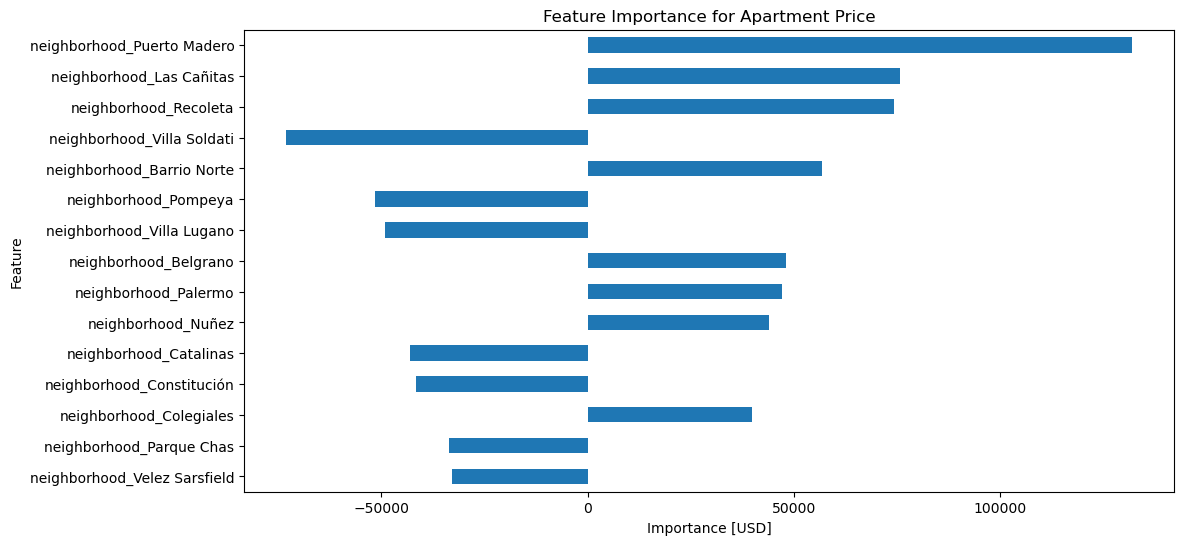

In [115]:
feat_imp.sort_values(key=abs).tail(15).plot(
    kind="barh",
    figsize=(12, 6)
)
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")
plt.title("Feature Importance for Apartment Price")
;

# 4. Predicting Price with Size, Location, and Neighborhood

Having explored size, location, and neighborhood individually, we'll now focus on combining multiple features to build a more robust and comprehensive model for predicting housing prices. 

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   6582 non-null   object 
 1   property_type               6582 non-null   object 
 2   price                       6582 non-null   float64
 3   currency                    6582 non-null   object 
 4   price_aprox_local_currency  6582 non-null   float64
 5   price_aprox_usd             6582 non-null   float64
 6   surface_total_in_m2         4752 non-null   float64
 7   surface_covered_in_m2       6582 non-null   float64
 8   price_usd_per_m2            4536 non-null   float64
 9   price_per_m2                6582 non-null   float64
 10  floor                       1900 non-null   float64
 11  rooms                       5286 non-null   float64
 12  expenses                    1739 non-null   object 
 13  properati_url               6582 

The first thing we need to consider when trying to use all the features `df` is **missing values**. While it's true you can impute missing values, there still needs to be enough data in a column to do a good imputation. A general rule is that, _if more than half of the data in a column is missing, it's better to drop it then try imputing._

Look at the output from `df.info()` above. Are there columns where more than half of the values are `NaN`? If so, those columns need to go! 

In [119]:
def wrangle(file_path):
    """Load and wrangle the housing data set."""
    # Load the CSV file
    df = pd.read_csv(file_path, sep=";", encoding="latin-1")

    # Subset the DataFrame with "Capital Federal" 
    mask = df["place_with_parent_names"].str.contains("Capital Federal", case=True)

    # Subset with "apartment"
    mask_apt = df["property_type"] == "apartment"

    # Subset with price less than to 400,000
    mask_price = df["price_aprox_usd"] < 400000

    # Apply all masks
    df = df[ mask & mask_apt & mask_price]
    
    # Remove outliers from "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Add columns 'lat' and 'lon'
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)

    # Drop columns "lat-lon"
    df.drop(columns=["lat-lon"], inplace=True)

    # Extract the neighborhood from "place_with_parent_names"
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]

    # Drop column "place_with_parent_names"
    df.drop(columns=["place_with_parent_names"], inplace=True)

    # Drop any columns that are more than half NaN values
    df = df.loc[:, df.isnull().mean() < 0.5]

    return df

In [120]:
frames = [wrangle(filepath) for filepath in files]
df = pd.concat(frames, ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   6582 non-null   object 
 1   property_type               6582 non-null   object 
 2   price                       6582 non-null   float64
 3   currency                    6582 non-null   object 
 4   price_aprox_local_currency  6582 non-null   float64
 5   price_aprox_usd             6582 non-null   float64
 6   surface_total_in_m2         4752 non-null   float64
 7   surface_covered_in_m2       6582 non-null   float64
 8   price_usd_per_m2            4536 non-null   float64
 9   price_per_m2                6582 non-null   float64
 10  rooms                       5286 non-null   float64
 11  properati_url               6582 non-null   object 
 12  lat                         6316 non-null   float64
 13  lon                         6316 

The next thing we need to look out for are categorical columns with **low or high cardinality**. If there's only one category in a column, it won't provide any unique information to our model. At the other extreme, columns where nearly every row has its own category won't help our model in identifying useful trends in the data.

Let's take a look at the cardinality of our features.

**Task 4.1:** Calculate the number of unique values for each non-numeric feature in `df`.


In [121]:
df.select_dtypes("object").nunique()

operation           1
property_type       1
currency            2
properati_url    6582
neighborhood       57
dtype: int64

Here, we can see that columns like `"operation"` have only one value in them, while every row in `"properati_url"` has a unique value. These are clear examples of high- and low-cardinality features that we shouldn't include in our model.

**Task 4.2:** Modify our `wrangle` function to drop high- and low-cardinality categorical features.

In [122]:
def wrangle(file_path):
    """Load and wrangle the housing data set."""
    # Load the CSV file
    df = pd.read_csv(file_path, sep=";", encoding="latin-1")

    # Subset the DataFrame with "Capital Federal" 
    mask = df["place_with_parent_names"].str.contains("Capital Federal", case=True)

    # Subset with "apartment"
    mask_apt = df["property_type"] == "apartment"

    # Subset with price less than to 400,000
    mask_price = df["price_aprox_usd"] < 400000

    # Apply all masks
    df = df[ mask & mask_apt & mask_price]
    
    # Remove outliers from "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Add columns 'lat' and 'lon'
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)

    # Drop columns "lat-lon"
    df.drop(columns=["lat-lon"], inplace=True)

    # Extract the neighborhood from "place_with_parent_names"
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]

    # Drop column "place_with_parent_names"
    df.drop(columns=["place_with_parent_names"], inplace=True)

    # Drop any columns that are more than half NaN values
    df = df.loc[:, df.isnull().mean() < 0.5]

    # Drop columns with high-low cardinality
    df.drop(columns=["property_type", "currency", "operation", "properati_url"], inplace=True)

    return df

In [123]:
frames = [wrangle(filepath) for filepath in files]
df = pd.concat(frames, ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   price                       6582 non-null   float64
 1   price_aprox_local_currency  6582 non-null   float64
 2   price_aprox_usd             6582 non-null   float64
 3   surface_total_in_m2         4752 non-null   float64
 4   surface_covered_in_m2       6582 non-null   float64
 5   price_usd_per_m2            4536 non-null   float64
 6   price_per_m2                6582 non-null   float64
 7   rooms                       5286 non-null   float64
 8   lat                         6316 non-null   float64
 9   lon                         6316 non-null   float64
 10  neighborhood                6582 non-null   object 
dtypes: float64(10), object(1)
memory usage: 565.8+ KB


It's also important for us to drop any columns that would constitute **leakage**, that is, features that were created using our target or that would give our model information that it won't have access to when it's deployed. 

In [124]:
sorted(df.columns)

['lat',
 'lon',
 'neighborhood',
 'price',
 'price_aprox_local_currency',
 'price_aprox_usd',
 'price_per_m2',
 'price_usd_per_m2',
 'rooms',
 'surface_covered_in_m2',
 'surface_total_in_m2']

Hence, we have to remove these columns 'price', 'price_aprox_local_currency', 'price_per_m2','price_usd_per_m2'.

In [125]:
def wrangle(file_path):
    """Load and wrangle the housing data set."""
    # Load the CSV file
    df = pd.read_csv(file_path, sep=";", encoding="latin-1")

    # Subset the DataFrame with "Capital Federal" 
    mask = df["place_with_parent_names"].str.contains("Capital Federal", case=True)

    # Subset with "apartment"
    mask_apt = df["property_type"] == "apartment"

    # Subset with price less than to 400,000
    mask_price = df["price_aprox_usd"] < 400000

    # Apply all masks
    df = df[ mask & mask_apt & mask_price]
    
    # Remove outliers from "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Add columns 'lat' and 'lon'
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)

    # Drop columns "lat-lon"
    df.drop(columns=["lat-lon"], inplace=True)

    # Extract the neighborhood from "place_with_parent_names"
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]

    # Drop column "place_with_parent_names"
    df.drop(columns=["place_with_parent_names"], inplace=True)

    # Drop any columns that are more than half NaN values
    df = df.loc[:, df.isnull().mean() < 0.5]

    # Drop columns with high-low cardinality
    df.drop(columns=["property_type", "currency", "operation", "properati_url"], inplace=True)

    # Drop leaky columns
    df.drop(columns=['price', 'price_aprox_local_currency', 'price_per_m2','price_usd_per_m2'], inplace=True)

    return df

In [126]:
frames = [wrangle(filepath) for filepath in files]
df = pd.concat(frames, ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_total_in_m2    4752 non-null   float64
 2   surface_covered_in_m2  6582 non-null   float64
 3   rooms                  5286 non-null   float64
 4   lat                    6316 non-null   float64
 5   lon                    6316 non-null   float64
 6   neighborhood           6582 non-null   object 
dtypes: float64(6), object(1)
memory usage: 360.1+ KB


Finally, the last issue we need to keep an eye out for is **multicollinearity**, that is, features in our feature matrix that are highly correlated with each other. A good way to detect this is to use a heatmap. Let's make one!

**Task 4.3:** Plot a correlation heatmap of the remaining numerical features in `df`. Since `"price_aprox_usd"` will be our target, we don't need to include it in our heatmap.


In [127]:
df.select_dtypes("number").drop(columns=["price_aprox_usd"]).corr() 

,surface_total_in_m2,surface_covered_in_m2,rooms,lat,lon
surface_total_in_m2,1.000000,0.735685,0.596368,0.070392,0.019021
surface_covered_in_m2,0.735685,1.000000,0.784979,0.028538,0.034515
rooms,0.596368,0.784979,1.000000,-0.048557,0.030434
lat,0.070392,0.028538,-0.048557,1.000000,-0.262439
lon,0.019021,0.034515,0.030434,-0.262439,1.000000


<Axes: >

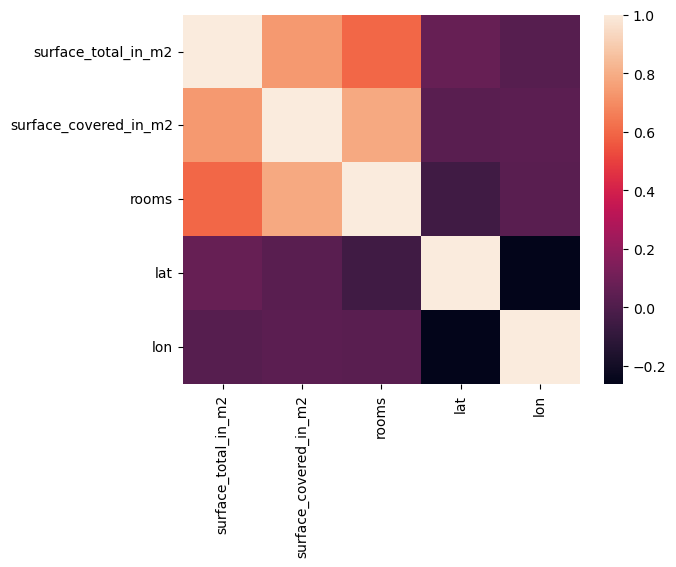

In [129]:
corr = df.select_dtypes("number").drop(columns=["price_aprox_usd"]).corr() 
sns.heatmap(corr)

 Let us remove columns so that there are no strongly correlated features in your feature matrix.

In [132]:
def wrangle(file_path):
    """Load and wrangle the housing data set."""
    # Load the CSV file
    df = pd.read_csv(file_path, sep=";", encoding="latin-1")

    # Subset the DataFrame with "Capital Federal" 
    mask = df["place_with_parent_names"].str.contains("Capital Federal", case=True)

    # Subset with "apartment"
    mask_apt = df["property_type"] == "apartment"

    # Subset with price less than to 400,000
    mask_price = df["price_aprox_usd"] < 400000

    # Apply all masks
    df = df[ mask & mask_apt & mask_price]
    
    # Remove outliers from "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Add columns 'lat' and 'lon'
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)

    # Drop columns "lat-lon"
    df.drop(columns=["lat-lon"], inplace=True)

    # Extract the neighborhood from "place_with_parent_names"
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]

    # Drop column "place_with_parent_names"
    df.drop(columns=["place_with_parent_names"], inplace=True)

    # Drop any columns that are more than half NaN values
    df = df.loc[:, df.isnull().mean() < 0.5]

    # Drop columns with high-low cardinality
    df.drop(columns=["property_type", "currency", "operation", "properati_url"], inplace=True)

    # Drop leaky columns
    df.drop(columns=['price', 'price_aprox_local_currency', 'price_per_m2','price_usd_per_m2'], inplace=True)

    # Drop columns with multicollinearity
    df.drop(columns=['surface_total_in_m2', 'rooms'], inplace=True)

    return df

In [133]:
frames = [wrangle(filepath) for filepath in files]
df = pd.concat(frames, ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_covered_in_m2  6582 non-null   float64
 2   lat                    6316 non-null   float64
 3   lon                    6316 non-null   float64
 4   neighborhood           6582 non-null   object 
dtypes: float64(4), object(1)
memory usage: 257.2+ KB


Done! It looks like we're going to use the four features we've used in our previous models but, this time, we're going to combine them.

#### Split Data

In [136]:
target = "price_aprox_usd"
features = df.columns.drop("price_aprox_usd").tolist()
X_train = df[features]
y_train = df[target]

#### Build Model

**Task 4.4:** Create a pipeline named `model` that contains a `OneHotEncoder`, `SimpleImputer`, and `Ridge` predictor.

In [138]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
)

model.fit(X_train, y_train)

,steps,"[('onehotencoder', ...), ('simpleimputer', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,verbose,0
,cols,['neighborhood']
,drop_invariant,False
,return_df,True
,handle_missing,'value'
,handle_unknown,'value'
,use_cat_names,True


**Task 4.5:** Calculate the training mean absolute error for our predictions as compared to the true targets in `y_train`.


In [139]:
y_pred_training = model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train, y_pred_training))

Training MAE: 24207.107190330295


#### Communicate Results

For this section, we've relied on equations and visualizations for communication about our model. In many data science projects, however, communication means giving stakeholders tools they can use to **deploy** a model, in other words, use it in action. So let's look at two ways you might deploy this model. 

One thing you might be asked to do it wrap our model in a function so that a programmer can provide inputs and then receive a prediction as output. 

**Task 4.6:** Let's create a function `make_prediction` that takes four arguments (`area`, `lat`, `lon`, and `neighborhood`) and returns our model's prediction for an apartment price. 

In [141]:
def make_prediction(area, lat, lon, neighborhood):
    # Create a DataFrame with the input values
    data = {
        "surface_covered_in_m2": area,
        "lat": lat,
        "lon": lon,
        "neighborhood": neighborhood
    }
    df = pd.DataFrame(data, index=[0])

    # Make prediction
    prediction = model.predict(df)
        
    return f"Predicted apartment price: ${prediction}"

In [142]:
make_prediction(110, -34.60, -58.46, "Villa Crespo")

'Predicted apartment price: $[250775.11270377]'

Another type of deployment is creating and interactive dashboard, where a user can supply values and receive a prediction. Let's create one using [Jupyter Widgets](https://ipywidgets.readthedocs.io/en/latest/index.html).

One of the most important parts of data science projects is creating products that people can use to make their work or lives easier.

In [144]:
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique())),
);

interactive(children=(IntSlider(value=53, description='area', max=101, min=30), FloatSlider(value=-34.59890626…